In [32]:
# The following lines enable automatic reloading of modules in an IPython/Jupyter environment.
# They work exactly like the commented lines below, but avoid errors when not running in such an environment.
# %load_ext autoreload
# %autoreload 2

try:
    # Only defined inside IPython/Jupyter
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")
except (NameError, AttributeError):
    # Not running in IPython → just ignore
    pass


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
pip install neptune


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [34]:
# Initializing answer variable
answer = {}


In [35]:
# Some libs that we will use
import torch
import random
import numpy as np
import json_tricks
import lovely_tensors as lt

# Making tensor printouts better
lt.monkey_patch()

# Adding sources to the pythonpath
import sys
root_path = '../../../..'
sys.path.append(root_path)

import dotenv
dotenv.load_dotenv(dotenv.find_dotenv(root_path + '/.env'))

# Importing sources of our project
import src


# Task 0: Prepare the environment

For that you have to fill out the function in `src/utils/seed.py`

Inside this function you should initialize the libs:
- `numpy`
- `random`
- `torch`

It is important for the reproducibility of your code and is always important when running experiments

Note that in `torch` you have to seed both `cpu` part of the package along with `gpu` part of the package

Yet another important thing to do there is to switch `gpu` to deterministic backend. Otherwise the experiments will not be fully reproducible

In [36]:
# src.utils.seed.seed_all(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


# Training a Fully Connected Feedforward Neural Network

In this exercise we will train an FCNN to classify digits into 10 classes (0, 1, 2, ..., 9).

To build such network, we will use:
- Fully Connected NN
- Adam Optimizer
- MNIST dataset
- Accuracy metrics
- Softmax final activation loss function (but we will embed it into the loss function)
- Cross-Entropy loss

But what really is important in this exercise is that we will build all the elements that we will in the future use to train all other networks. Thus, this exercise is needed to settle the basis for all our future experiments. If you will work with training neural networks, you will use all that we will touch in this notebook in different scenarios.

Thus, this notebook is way closer to the real training scenarios than the previous ones.

# Task 1: Prepare the data

What you will be doing in this task is preparing your first dataloader class for one of the most popular datasets for Machine Learning -- MNIST

The task is to fill out `src/datasets/mnist_simple.py` file so that you get a correctly working class of dataset (this file should open in parallel to your notebook).

You have to fill out the following parts of code:
- `__init__` function (a constructor)
- `__len__` function (an operator of `len(object)`)
- `__getitem__` function (that enables indexing in form of `object[index]`)

You will be doing all that when you will be writing your own datasets with one exception: your classes will have significantly more complicated logics.

The task here is:
- In `__init__` get MNIST dataset from `torchvision.datasets` and initialize it. 
    Store the data in your home directory (`~/`) to avoid overloading your repo. 
    Note that you have to account for training and validation datasets that are controlled by the flag `train`
- In `__getlen__` the task is to return the number of samples in your data. 
    It should be number of images in the dataset object

- Lastly, you have to implement indexing operator `__getitem__(self, index)`
    In this method you should:
    - get the image
    - get the label
    - preprocess the image. This step contains:
        - transform the image to a float tensor (the reason is that half is not suppoerted for CPUs)
        - a good practice is to normalize the input data to have mean 0 and variance 1, so we should normalize it.
            Althouth we do not know exactly the mean and the variance of the dataset, but assuming that every pixel
            is in the range 0-255, we can assume that the mean is 127 and the variance is 127.
            So we can approximately normalize the input by (x / 255) * 2 - 1
            Yes, that is not an exact normalization, but haaving data within range (-1, 1) is a good approximation of normalization
    - return the image and the label

After that fill out the cell below that initializes objects of the class

In [37]:
import torchvision.datasets

class MNISTSimpleDataset:
    def __init__(self, train=True):
        dataset = torchvision.datasets.MNIST(root='~/', train=train, download=True)
        self.X = dataset.data
        self.y = dataset.targets

    def __len__(self):
        res = len(self.y)
        return res


    def __getitem__(self, index):
        sample = {}
        sample['image'] = self.X[index, :, :].float() / 255.0 * 2 - 1
        sample['label'] = self.y[index].long()
        
        return sample 

In [38]:
MNIST_train = MNISTSimpleDataset(train=True)
MNIST_valid = MNISTSimpleDataset(train=False)


Check that the data is prepared:

In [39]:
train_sample = MNIST_train[0]
valid_sample = MNIST_valid[0]

X_train = train_sample['image']
X_valid = valid_sample['image']
y_train = train_sample['label']
y_valid = valid_sample['label']


In [40]:
## This checks are for dataset verification
answer['X_train.dtype'] = str(X_train.dtype)
answer['y_train.dtype'] = str(y_train.dtype)
answer['X_valid.dtype'] = str(X_valid.dtype)
answer['y_valid.dtype'] = str(y_valid.dtype)
answer['X_train.shape'] = X_train.shape
answer['X_valid.shape'] = X_valid.shape
answer['y_train.shape'] = y_train.shape
answer['y_valid.shape'] = y_valid.shape
answer['X_train.mean'] = float(X_train.mean())
answer['y_train.mean'] = float(y_train.float().mean())
answer['X_valid.mean'] = float(X_valid.mean())
answer['y_valid.mean'] = float(y_valid.float().mean())

print(X_train.dtype, X_valid.dtype, y_train.dtype, y_valid.dtype)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

print(X_train)
print(X_valid)
print(y_train)
print(y_valid)


torch.float32 torch.float32 torch.int64 torch.int64
torch.Size([28, 28]) torch.Size([28, 28]) torch.Size([]) torch.Size([])
tensor[28, 28] n=784 (3.1Kb) x∈[-1.000, 1.000] μ=-0.725 σ=0.625
tensor[28, 28] n=784 (3.1Kb) x∈[-1.000, 1.000] μ=-0.815 σ=0.518
tensor i64 5
tensor i64 7


Neural networks are usually trained in float values. Usually in `float32` or `float16`. In this exercise we will use `float32` precision.

Convert your data to `float` type

Let us visualize the data that we have

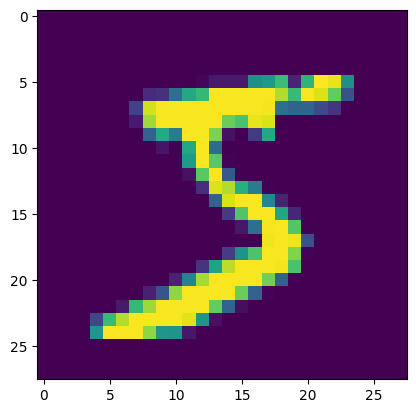

tensor i64 5


In [41]:
import matplotlib.pyplot as plt
plt.imshow(X_train)
plt.show()
print(y_train)


# Task 2: Build the code for the network

It is time to create our neural network (edit the file `src/models/feedforward/simple_fcnn.py`, should be open automatically with this chapter).

In pytorch to enable all the magic for training, people enherit their models from `torch.nn.Module`.

This enables many utilities that will be used in the future.

The main two methods that we have to fill are:
- `__init__` method that creates all modules of Neural Network
    NOTE: you should also intialize the parent class's instance(`torch.nn.Module` by calling `super().__init__()`)
- `__call__` method that is used to calculate preditions


We will create a network for quite a general case of Fully-Connected Neural Network

Here is the network that you should create:
- it should have the structure:
    - `network`:
        - `Linear channels[0] -> channels[1] -> activation`
        - `Linear channels[1] -> channels[2] -> activation`
        - and so on
    - `classifier`:
        - `Linear channels[n] -> n_classes`
- the signals that you create should traverse the initialized modules according to the order above

That is the simple n-layer fully connected network.

The network should have two parts:
- `backbone` (containing all the layers except for the last linear layer)
- `classifier` (containing only the last layer)

We like to isolate the classifier separately because it is a very special layer of the network.

It also is a very good practice to wrap the modules where one block is executed after another
into a `torch.nn.Sequential`.

Note that in theory, we should use a SoftMax activation in the end. 
But in our case, this activation will be joined with the loss function due to mathematical reasons.

Let us check that your network actually works

In [42]:
import torch

class SimpleFCNN(torch.nn.Module):
    def __init__(
            self, 
            channels=[],
            n_classes=10,
            activation=torch.nn.ReLU):
        super().__init__()
        layers = []
        for i in range(len(channels) - 1):
            layers.append(torch.nn.Linear(channels[i], channels[i+1]))
            layers.append(activation())

        self.backbone = torch.nn.Sequential(*layers)
        self.classifier = torch.nn.Linear(channels[-1], n_classes)

    def forward(self, signal):
        res = signal.reshape([signal.shape[0], -1])
        res = self.backbone(res)
        res = self.classifier(res)
        return res

In [43]:
simple_network = src.models.feedforward.simple_fcnn.SimpleFCNN([28 * 28], n_classes=10)

src.utils.deterministic_init(simple_network)

check_input = {'image': torch.randn(10, 28 * 28)}
check_output = simple_network(check_input['image'])

answer['check_result'] = src.utils.detach_copy(check_output)


# Task 3: Create loss function and optimizer



All right, so now we have prepared the dataset and the network.
We are still missing several other modules that are important for model training:
- optimizer
- loss function
- metrics

To train this network we will use the following components:
- `AdamW` as an optimizer (`torch.optim.AdamW`) with standard parameters and `lr` equal to $3 \cdot 10^{-4}$
- `CE` as a loss function (`torch.nn.CrossEntropy`). Note that this loss function already includes `SoftMax` activation function (and we should remember that this activation is compatible with this loss function). We could code it ourselves, it is not hard, but the standard implementation from pytorch is numerically more stable
- `accuracy` as a metrics (we will use the one coded in `torchmetrics`)

There are also several training tricks that are very nice to use.
As such, we will use the learning rate scheduler `torch.optim.schedulers.ReduceLROnPlateu`

Let us prepare what we need now!

In [ ]:
import torchmetrics

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(simple_network.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
metrics = torchmetrics.Accuracy(task='multiclass', num_classes=10)


In [45]:
answer['loss'] = str(loss)
answer['optimizer'] = str(optimizer)
answer['scheduler'] = str(scheduler)
answer['metrics'] = str(metrics)

print(loss)
print(optimizer)
print(scheduler)
print(metrics)


CrossEntropyLoss()
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0.01
)
MulticlassAccuracy()


# Task 4: Create DataLoaders

Now it is time to start the training process

Firstly, we need to turn our datasets into dataloaders (dataloaders know, how to create batches of data and takes care of shuffling them)

You should use the class `torch.utils.data.DataLoader` to create training and validation dataloaders.

What is important here is that you should shuffle the data for training, while you should not do it during validation.

Also the last batch of the training dataloader may be deficient and should be dropped (there is a special option in the DataLoader class dedicated for that).

Use batch size that is given below

In [46]:
from tqdm import trange, tqdm
import os

batch_size = 32

train_dl = torch.utils.data.DataLoader(
    MNIST_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True)

valid_dl = torch.utils.data.DataLoader(
    MNIST_valid,
    batch_size=batch_size,
    shuffle=False)


# Task 5: Create training loop

Firstly, we will use a service that allows to share the training reports. I strongly recommend using mlflow for your experiments, but for the sake of being able to share the results, we will use [neptune.ai](https://neptune.ai/)

Create an account there, create your first experiment (and name it something like `MNIST FCNN`)

Then create run with `neptune.ai` in your code.

After that you will be able to see on that website the flow of your experiment.

Then it is time to create the training cycle.

Training cycles usually are custom for every network, because of that we will not create one for all the cases.

Training cycles run in epochs each containing 2 stages:
- training
- validation

Here is what you should do in the training stage:
1. extract training batch from training dataloader
2. switch the network to training state (`model.train()`)(will be important for batchnorms and some other modules)
2. generate predictions from the training inputs using the model (`model(inputs)`)
3. calculate the value of the loss that compares the predictions to the targets
4. perform backpropagation (`loss_val.backward()`)
5. make optimization step  with optimizer (`optimizer.step()`)
6. reset optimizer's gradients (`optimizer.zero_grad()`)
7. switch the network to validation state (`model.eval()`)
8. evaluate training the accuracy of your model and update metrics that keep track of accuracy and loss (averaged throughout the training step)

This should be done in iterations for all training batches that come out from `train_dl`

Note that it is extremely important to do `detach` when you memorize accuracy and loss values so that after each iteration RAM is freed automatically by pytorch (because in case we plan to perform backprop, all the intermediate values are needed, and cannot be freed).

Once in a while, if you experience RAM leakage, you should make sure that you detach metrics and loss values that you memorize. In case that does not help, delete all the variables manually and after that call pythons's garbage collector (`gc.collect()`). This will help pytorch with cleaning RAM.

If you do not want to think about detaching and other aspects of graph backpropagation in some part of your code, you may use `torch.no_grad()` context. Exactly that statement we will use during validation stage of the cycle. This context also can be used as a decorator of a function that does not require gradient propagation.

Now it is time to do validation:
- make prediction for validation data
- calculate accuracy for the predictions for both sets
- calculate loss function for the predictions for both sets

Note that the code should look very similarly to training cycle. The only difference is that this time we do not perform backpropagation and optimizer step.

By the end of each epoch, submit the report about accuracies that you gotten and loss values to neptune.ai (run['losses/loss_value/train'].log(train_loss_value))

In [ ]:
n_epochs = 5

def train_model(model, n_epochs, train_dl, valid_dl, loss, optimizer):
    train_loss_history = []
    train_acc_history = []
    valid_loss_history = []
    valid_acc_history = []

    ## INITILIZING EXPERIMENT TRACKER (neptune.ai, mlflow, tensorboard, etc)
    # run = neptune.init_run(
        ## YOUR CODE HERE
    # )

    for epoch in range(n_epochs):
        train_loss = {'enumerator': 0.0, 'denominator': 1.0e-8}
        train_acc = {'enumerator': 0.0, 'denominator': 1.0e-8}
        valid_loss = {'enumerator': 0.0, 'denominator': 1.0e-8}
        valid_acc = {'enumerator': 0.0, 'denominator': 1.0e-8}

        print(epoch + 1, '/', n_epochs)

        for batch in tqdm(train_dl):
            images = batch['image'].view(-1, 28*28)
            labels = batch['label']

            outputs = model(images)
            loss_value = loss(outputs, labels)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            train_loss['enumerator'] += loss_value.item() * images.size(0)
            train_loss['denominator'] += images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            train_acc['enumerator'] += (predicted == labels).sum().item()
            train_acc['denominator'] += images.size(0)
        
        model.eval()

        with torch.no_grad():
            for valid_batch in tqdm(valid_dl):
                images = batch['image'].view(-1, 28*28)
                lables = batch['label']

                outputs = model(images)
                loss_value = loss(outputs, labels)

                valid_loss['enumerator'] += loss_value.item() * images.size(0)
                valid_loss['denominator'] += images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                valid_acc['enumerator'] += (predicted == labels).sum().item()
                valid_acc['denominator'] += labels.size(0)

            print(valid_acc['enumerator'] / valid_acc['denominator'], '<- Validation accuracy debug')

            finalized_train_loss = train_loss['enumerator'] / train_loss['denominator']
            finalized_train_accuracy = train_acc['enumerator'] / train_acc['denominator']

            finalized_valid_loss = valid_loss['enumerator'] / valid_loss['denominator']
            finalized_valid_accuracy = valid_acc['enumerator'] / valid_acc['denominator']

            # Logging the progress to tracker

            train_loss_history.append(finalized_train_loss)
            train_acc_history.append(finalized_train_accuracy)
            valid_loss_history.append(finalized_valid_loss)
            valid_acc_history.append(finalized_valid_accuracy)

    # Stopping the experiment tracker
    # run.stop()
    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history

train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = train_model(simple_network, n_epochs, train_dl, valid_dl, loss, optimizer)


1 / 5


100%|██████████| 313/313 [00:01<00:00, 312.20it/s]


0.49999999999950073 <- Validation accuracy debug
2 / 5


100%|██████████| 313/313 [00:00<00:00, 398.41it/s]


0.6874999999993135 <- Validation accuracy debug
3 / 5


100%|██████████| 313/313 [00:00<00:00, 372.04it/s]


0.7187499999992824 <- Validation accuracy debug
4 / 5


100%|██████████| 313/313 [00:01<00:00, 262.10it/s]


0.78124999999922 <- Validation accuracy debug
5 / 5


100%|██████████| 313/313 [00:00<00:00, 352.95it/s]

0.8749999999991264 <- Validation accuracy debug


In [48]:
answer['train_loss_history'] = train_loss_history
answer['valid_loss_history'] = valid_loss_history
answer['train_acc_history'] = train_acc_history
answer['valid_ann_history'] = valid_acc_history

json_tricks.dump(answer, '.answer.json')


'{"X_train.dtype": "torch.float32", "y_train.dtype": "torch.int64", "X_valid.dtype": "torch.float32", "y_valid.dtype": "torch.int64", "X_train.shape": [28, 28], "X_valid.shape": [28, 28], "y_train.shape": [], "y_valid.shape": [], "X_train.mean": -0.7246397137641907, "y_train.mean": 5.0, "X_valid.mean": -0.815386176109314, "y_valid.mean": 7.0, "check_result": {"__ndarray__": [[47.534400939941406, 36.74652099609375, 25.958641052246094, 15.170763969421387, 4.38288688659668, -6.404989242553711, -17.1928653717041, -27.98073959350586, -38.76861572265625, -49.55651092529297], [34.737178802490234, 26.7078914642334, 18.678592681884766, 10.649308204650879, 2.6200146675109863, -5.409275054931641, -13.438562393188477, -21.467849731445312, -29.497146606445312, -37.526432037353516], [-26.242555618286133, -20.858619689941406, -15.474696159362793, -10.0907564163208, -4.706827640533447, 0.6771035194396973, 6.061039924621582, 11.44497013092041, 16.828895568847656, 22.212844848632812], [-48.4908370971679

# Task 7. Experiment time!

It is the time for fun now!

We have created everything that is needed for the network to train.

Let us train some networks and visualize, what they see.

With the code that you have created, make:
- 1-layer FCNN (yes, simple Multiclass Logistic Regression)
- 2-layer FCNN
- 3-layer FCNN 

Train every of these networks for 100 epochs

Check, what are the patterns that they learn

To check the patterns, you have to take the weights of the first layer of the network, reshape them and plot.

In [49]:
one_layer_fcnn = src.models.feedforward.simple_fcnn.SimpleFCNN(
    [28 * 28],
    n_classes=10,
    activation=torch.nn.LeakyReLU)

## YOUR CODE HERE

one_layer_optimizer = torch.optim.AdamW(one_layer_fcnn.parameters(), lr=1.0e-3)
train_model(one_layer_fcnn, n_epochs, train_dl, valid_dl, loss, one_layer_optimizer)
## YOUR CODE HERE


1 / 5


100%|██████████| 313/313 [00:00<00:00, 348.75it/s]


0.9062499999990952 <- Validation accuracy debug
2 / 5


100%|██████████| 313/313 [00:00<00:00, 324.88it/s]


0.937499999999064 <- Validation accuracy debug
3 / 5


100%|██████████| 313/313 [00:00<00:00, 361.21it/s]


0.937499999999064 <- Validation accuracy debug
4 / 5


100%|██████████| 313/313 [00:01<00:00, 301.48it/s]


0.937499999999064 <- Validation accuracy debug
5 / 5


100%|██████████| 313/313 [00:01<00:00, 289.32it/s]

0.8124999999991888 <- Validation accuracy debug


([0.4284790127077978,
  0.3254517220456853,
  0.3104273729254285,
  0.3047023269861429,
  0.29976520795568795],
 [0.8772833333331872,
  0.9058166666665157,
  0.9113333333331815,
  0.9130166666665145,
  0.9138333333331811],
 [0.5193895101542055,
  0.35246470570529076,
  0.18337394297104645,
  0.17002278566343498,
  0.3813928663726813],
 [0.9062499999990952,
  0.937499999999064,
  0.937499999999064,
  0.937499999999064,
  0.8124999999991888])

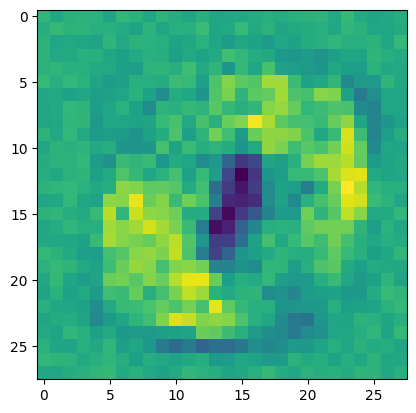

In [50]:
W = one_layer_fcnn.classifier.weight
W = W.reshape(10, 28, 28)
plt.imshow(W[0].detach())


In [51]:
## YOUR CODE HERE


# Time to think

What converges faster
- 1-layer NN (Logistic Regression)
- 2-layer NN
- 3-layer NN

Maybe you want to train a deeper network? Say, with 10 layers?

What do the patterns from 1-layer NN resemble? Should they?
What do the patterns from 2-layer and 3-layer NN resemble? Should they?

# Task 8. More experiments!

Try to train the networks created above with different actiavtion functions (Concentrate on 2-Layer NN):
- Sigmoid
- Tanh
- ReLU
- LeakyReLU
- Swish

Try to train them with optimizers
- AdamW
- SGD

Which one is easier to tune?

Try to train these networks on Google Colab for longer
Find the best possible batch size (note that the batch sizes usually are selected as powers of 2)
- 2
- 4
- 8
- 16
- etc.

Share your best recepie with everyone and discuss, how did you improve your results